In [1]:
from PREDICT.data_sources import radar_loaders as rad
from PREDICT.data_sources import satellite_loaders as sat
import cartopy.crs as ccrs
import numpy as np
import decimal
from scipy.interpolate import griddata
from PREDICT.utils import file_utils as futils
from PREDICT.L1_processing import radar as l1rad
from PREDICT.L2_processing import radar as l2rad
from PREDICT.utils import geospatial as gutils
import matplotlib.pyplot as plt
from PREDICT.visualisation import geospatial as gvis
import importlib
import pandas as pd
importlib.reload(futils)
importlib.reload(l2rad)

<module 'PREDICT.L2_processing.radar' from '/home/jovyan/PREDICT/PREDICT/L2_processing/radar.py'>

## Pipeline for loading raw radar data, satellite products, extract on the same zone and visualize

### Radar Loading and geo referencing

We will be using French Guiana's radar as an example 

In [2]:
dir_path_l0 = '/home/jovyan/data/share/rodrigo/data/raw_data/brazil/pernambuco/radar/'

df_paths_dates_radar = futils.get_df_dates_filepaths(dir_path_l0) # this function constructs a df with the filepahts and dates for each file

display(df_paths_dates_radar.head())

,paths
time,
2017-05-19 00:00:01,/home/jovyan/data/share/rodrigo/data/raw_data/...
2017-05-19 00:00:01,/home/jovyan/data/share/rodrigo/data/raw_data/...
2017-05-19 00:00:01,/home/jovyan/data/share/rodrigo/data/raw_data/...
2017-05-19 00:00:01,/home/jovyan/data/share/rodrigo/data/raw_data/...
2017-05-19 00:00:01,/home/jovyan/data/share/rodrigo/data/raw_data/...


In [3]:
date = '2020-03-18'

fpaths_rad = df_paths_dates_radar.loc[date, :].paths.tolist()

elevation = 0

# open multifile
ds_rad = rad.open_mf_pernambuco_dataset(fpaths_rad, elevation) # this function loads the radar dataset for this date



In [4]:
display(ds_rad)

<xarray.Dataset>
Dimensions:            (azimuth: 360, range: 1000, time: 144)
Coordinates:
  * azimuth            (azimuth) float64 1.0 2.0 3.0 4.0 ... 358.0 359.0 360.0
  * range              (range) float32 125.0 375.0 625.0 ... 2.496e+05 2.499e+05
    elevation          (azimuth) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rtime              (time, azimuth) datetime64[ns] dask.array<chunksize=(1, 360), meta=np.ndarray>
    longitude          float64 -35.46
    latitude           float64 -8.192
    altitude           float64 626.0
  * time               (time) datetime64[ns] 2020-03-18T00:00:03.041666500 .....
Data variables: (12/14)
    DBTH               (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 1000), meta=np.ndarray>
    sweep_mode         (time) <U20 'azimuth_surveillance' ... 'azimuth_survei...
    sweep_number       (time) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    prt_mode           (time) <U7 'not_set' 'not_set' ... 'not_set' 'not_set'
    follow_mode        (time) <U7 'not_set' 'not_set' ... 'not_set' 'not_set'
    sweep_fixed_angle  (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...                 ...
    PHIDP              (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 1000), meta=np.ndarray>
    RHOHV              (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 1000), meta=np.ndarray>
    VRADH              (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 1000), meta=np.ndarray>
    WRADH              (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 1000), meta=np.ndarray>
    ZDR                (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 1000), meta=np.ndarray>
    uPhiDP             (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 1000), meta=np.ndarray>

In [5]:
georef_ds = l1rad.calculate_georeferencing(ds_rad)
display(georef_ds)

<xarray.Dataset>
Dimensions:            (azimuth: 360, range: 1000, time: 144)
Coordinates:
  * azimuth            (azimuth) float64 1.0 2.0 3.0 4.0 ... 358.0 359.0 360.0
  * range              (range) float32 125.0 375.0 625.0 ... 2.496e+05 2.499e+05
    elevation          (azimuth) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rtime              (time, azimuth) datetime64[ns] dask.array<chunksize=(1, 360), meta=np.ndarray>
    longitude          float64 -35.46
    latitude           float64 -8.192
    altitude           float64 626.0
  * time               (time) datetime64[ns] 2020-03-18T00:00:03.041666500 .....
    lon                (azimuth, range) float64 -35.46 -35.46 ... -35.46 -35.46
    lat                (azimuth, range) float64 -8.191 -8.189 ... -5.948 -5.946
    alt                (azimuth, range) float64 1.252e+03 ... 4.926e+03
Data variables: (12/14)
    DBTH               (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 1000), meta=np.ndarray>
    sweep_mode         (time) <U20 'azimuth_surveillance' ... 'azimuth_survei...
    sweep_number       (time) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    prt_mode           (time) <U7 'not_set' 'not_set' ... 'not_set' 'not_set'
    follow_mode        (time) <U7 'not_set' 'not_set' ... 'not_set' 'not_set'
    sweep_fixed_angle  (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...                 ...
    PHIDP              (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 1000), meta=np.ndarray>
    RHOHV              (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 1000), meta=np.ndarray>
    VRADH              (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 1000), meta=np.ndarray>
    WRADH              (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 1000), meta=np.ndarray>
    ZDR                (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 1000), meta=np.ndarray>
    uPhiDP             (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 1000), meta=np.ndarray>

### Satellite product loading 

We will be seeing IMERG's late rendition of this day

In [6]:
dir_path_im = '/home/jovyan/data/share/rodrigo/data/raw_data/imerg_late/'

df_paths_dates_imerg = futils.get_df_dates_filepaths(dir_path_im) # this function constructs a df with the filepahts and dates for each file

display(df_paths_dates_radar.head())

,paths
time,
2017-05-19 00:00:01,/home/jovyan/data/share/rodrigo/data/raw_data/...
2017-05-19 00:00:01,/home/jovyan/data/share/rodrigo/data/raw_data/...
2017-05-19 00:00:01,/home/jovyan/data/share/rodrigo/data/raw_data/...
2017-05-19 00:00:01,/home/jovyan/data/share/rodrigo/data/raw_data/...
2017-05-19 00:00:01,/home/jovyan/data/share/rodrigo/data/raw_data/...


In [7]:
fpaths_ime = df_paths_dates_imerg.loc[date, :].paths.tolist()

ds_sat = sat.open_mf_imerg(fpaths_ime, field='precipitationCal') # this function loads the imerg dataset for this date only the precipCal field

display(ds_sat)

<xarray.Dataset>
Dimensions:           (time: 48, lon: 3600, lat: 1800)
Coordinates:
  * time              (time) datetime64[ns] 2020-03-18 ... 2020-03-18T23:30:00
  * lon               (lon) float32 -179.9 -179.9 -179.8 ... 179.8 179.9 179.9
  * lat               (lat) float32 -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
Data variables:
    precipitationCal  (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
Attributes:
    GridHeader:  BinMethod=ARITHMETIC_MEAN;\nRegistration=CENTER;\nLatitudeRe...

### First Look

/tmp/ipykernel_101/202059250.py:1: DeprecationWarning: Once the behaviour of DataArray.argmin() and Variable.argmin() without dim changes to return a dict of indices of each dimension, for consistency it will be an error to call Dataset.argmin() with no argument,since we don't return a dict of Datasets.
  idxplot = georef_ds.mean(dim=['range', 'azimuth']).argmax().DBZH.data.compute()
/home/jovyan/.conda/envs/radar_env/lib/python3.11/site-packages/dask/array/reductions.py:1073: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)


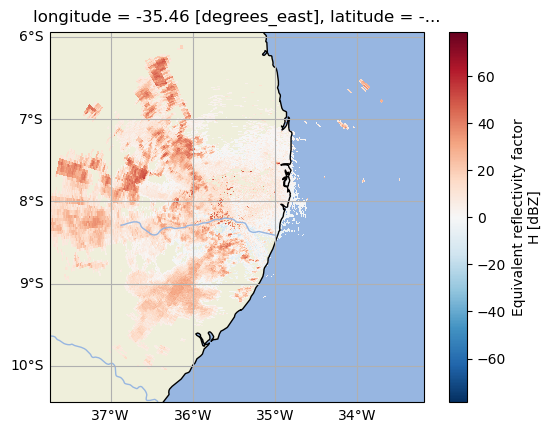

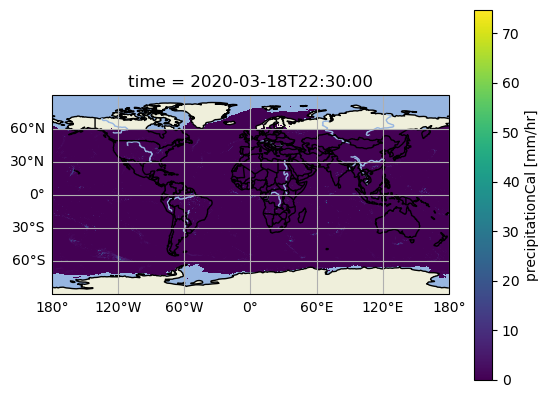

In [8]:
idxplot = georef_ds.mean(dim=['range', 'azimuth']).argmax().DBZH.data.compute()
tplot = georef_ds.time[idxplot].data

gvis.plot_simple_map()
ax = plt.gca()
georef_ds.sel({'time': tplot}, method='nearest').DBZH.plot(x='lon', y='lat', ax=ax)
plt.show()

gvis.plot_simple_map()
ax = plt.gca()
ds_sat.sel({'time': tplot}, method='nearest').precipitationCal.plot(x='lon', y='lat', ax=ax)
plt.show()


As you can see, not very helpful.

Now, with the functions of `PREDICT.utils.geospatial`, particularly `get_data_in_bbox` and `get_bbox_from_xarray`, we'll see it better

### Extracting data in radar area

In [9]:
bbox = gutils.get_bbox_from_xarray(georef_ds)
ime_bbox = gutils.get_data_in_bbox(ds_sat, bbox)

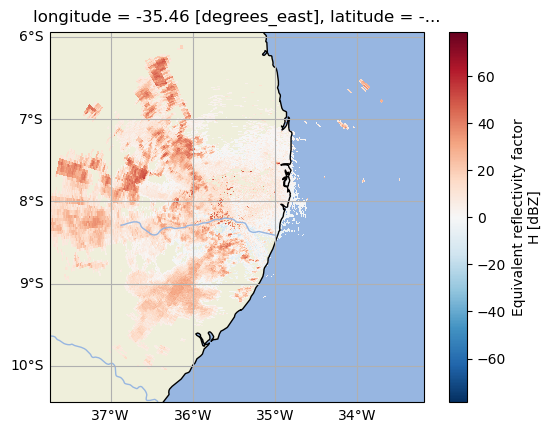

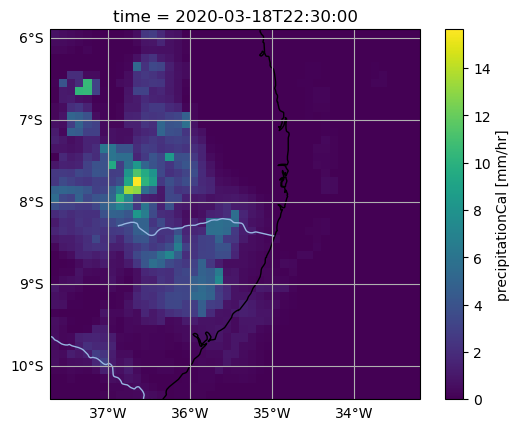

In [10]:
# Let's try it one more time

gvis.plot_simple_map()
ax = plt.gca()
georef_ds.sel({'time': tplot}, method='nearest').DBZH.plot(x='lon', y='lat', ax=ax)
plt.show()

gvis.plot_simple_map()
ax = plt.gca()
ime_bbox.sel({'time': tplot}, method='nearest').precipitationCal.plot(x='lon', y='lat', ax=ax)
plt.show()

### Let's now calculate the rain rate from the reflectivity

In [11]:
l2rad.calc_rate_from_refl(78.5-10)

696.7969687523527

In [12]:
georef_ds.DBZH.sel({'time': tplot}).max().compute()

<xarray.DataArray 'DBZH' ()>
array(78.5, dtype=float32)
Coordinates:
    longitude  float64 -35.46
    latitude   float64 -8.192
    altitude   float64 626.0
    time       datetime64[ns] 2020-03-18T22:30:03.041666500

In [14]:
rain_ds = l2rad.calc_rate_from_refl(georef_ds.DBZH, offset=0)

In [15]:
ds_rads = [rad.open_mf_pernambuco_dataset(fpaths_rad, i) for i in range(3)]
georefs = [l1rad.calculate_georeferencing(ds) for ds in ds_rads]

In [16]:
rat_v0 = l2rad.calculate_radar_estimate_averaging_elevations(georefs, ref_var='DBZH', offset=-6)

In [17]:
rat_v0

<xarray.Dataset>
Dimensions:    (time: 144, azimuth: 360, range: 1000)
Coordinates:
  * time       (time) datetime64[ns] 2020-03-18T00:00:03.041666500 ... 2020-0...
  * azimuth    (azimuth) float64 1.0 2.0 3.0 4.0 5.0 ... 357.0 358.0 359.0 360.0
  * range      (range) float32 125.0 375.0 625.0 ... 2.496e+05 2.499e+05
    lon        (azimuth, range) float64 -35.46 -35.46 -35.46 ... -35.46 -35.46
    lat        (azimuth, range) float64 -8.191 -8.189 -8.186 ... -5.949 -5.947
Data variables:
    rain_rate  (time, azimuth, range) float64 0.05668 0.01244 ... nan nan

In [ ]:
# Let's try it one more time

gvis.plot_simple_map()
ax = plt.gca()
rat_v0.rain_rate.sel({'time': tplot}, method='nearest').plot(x='lon', y='lat', ax=ax, vmin=0, vmax=37.73)
plt.show()

gvis.plot_simple_map()
ax = plt.gca()
ime_bbox.sel({'time': tplot}, method='nearest').precipitationCal.plot(x='lon', y='lat', ax=ax)
plt.show()

We see that the scales are quite different we should regrid our radar to match the satellite resolution

In [ ]:
# WORK IN PROGRESS

single_ds = rat_v0.sel({'time': tplot}, method='nearest')

lons, lats = single_ds.lon.values.flatten(), rain_ds.lat.values.flatten()
values = single_ds.rain_rate.fillna(0).values.flatten()

ppoints = np.array([lons, lats]).T

res = 0.1
decimals = -(decimal.Decimal(str(res))).as_tuple().exponent

lon_min, lon_max = np.round((lons.min(), lons.max()), decimals=decimals)
lon_grid = np.arange(lon_min, lon_max+res, res)

lat_min, lat_max = np.round((lats.min(), lats.max()), decimals=decimals)
lat_grid = np.arange(lat_min, lat_max+res, res)

grid_lon, grid_lat = np.meshgrid(lon_grid, lat_grid)

grid_z = griddata(ppoints, values, (grid_lon, grid_lat), method='linear')

In [ ]:
gvis.plot_simple_map()
im = plt.pcolormesh(lon_grid, lat_grid, (grid_z), vmin=0, vmax=15)
plt.colorbar(im)
plt.show()

gvis.plot_simple_map()
ax = plt.gca()
ime_bbox.sel({'time': tplot}, method='nearest').precipitationCal.plot(x='lon', y='lat', ax=ax)
plt.show()

In [ ]:
rat_v0.sel({'time':tplot}).quantile(0.99)